# HW2P2: Face Classification and Verification


Congrats on coming to the second homework in 11785: Introduction to Deep Learning. This homework significantly longer and tougher than the previous homework. You have 2 sub-parts as outlined below. Please start early!


*   Face Recognition: You will be writing your own CNN model to tackle the problem of classification, consisting of 7001 identities
*   Face Verification: You use the model trained for classification to evaluate the quality of its feature embeddings, by comparing the similarity of known and unknown identities

Common errors which you may face in this homeworks (because of the size of the model)


*   CUDA Out of Memory (OOM): You can tackle this problem by (1) Reducing the batch size (2) Calling `torch.cuda.empty_cache()` and `gc.collect()` (3) Finally restarting the runtime



# Preliminaries

In [ ]:
!nvidia-smi # to see what GPU you have

In [ ]:
!pip install wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 28.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00


In [1]:
import torch
from torchsummary import summary
import torchvision #This library is used for image-based operations (Augmentations)
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import wandb
import matplotlib.pyplot as plt
from convnext import *
from siamese_net import *
from mobilenet import *
from efficientnet import *
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
%load_ext autoreload
%autoreload 2
print("Device: ", DEVICE)

/home/alice/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device:  cuda


In [ ]:
from google.colab import drive # Link your drive if you are a colab user
drive.mount('/content/drive') # Models in this HW take a long time to get trained and make sure to save it her

Mounted at /content/drive


# TODOs
As you go, please read the code and keep an eye out for TODOs!

# Download Data from Kaggle

In [ ]:
# TODO: Use the same Kaggle code from HW1P2

In [ ]:
!mkdir '/content/data'

!kaggle competitions download -c 11-785-f23-hw2p2-classification
!unzip -qo '11-785-f23-hw2p2-classification.zip' -d '/content/data'

!kaggle competitions download -c 11-785-f23-hw2p2-verification
!unzip -qo '11-785-f23-hw2p2-verification.zip' -d '/content/data'

# Configs

In [2]:
config = {
    'batch_size': 64, # Increase this if your GPU can handle it
    'lr': 0.05,
    'epochs': 40, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    # Include other parameters as needed.
}

# Classification Dataset

In [3]:
DATA_DIR    = '11-785-f23-hw2p2-classification'# TODO: Path where you have downloaded the data
TRAIN_DIR   = os.path.join(DATA_DIR, "train")
VAL_DIR     = os.path.join(DATA_DIR, "dev")
TEST_DIR    = os.path.join(DATA_DIR, "test")

# Transforms using torchvision - Refer https://pytorch.org/vision/stable/transforms.html

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomAffine(30),
    torchvision.transforms.ToTensor()
])# Implementing the right train transforms/augmentation methods is key to improving performance.

# Most torchvision transforms are done on PIL images. So you convert it into a tensor at the end with ToTensor()
# But there are some transforms which are performed after ToTensor() : e.g - Normalization
# Normalization Tip - Do not blindly use normalization that is not suitable for this dataset

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform= valid_transforms)
# You should NOT have data augmentation on the validation set. Why?


# Create data loaders
train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 0,
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 0
)

In [4]:
# You can do this with ImageFolder as well, but it requires some tweaking
class ClassificationTestDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, transforms):
        self.data_dir   = data_dir
        self.transforms = transforms

        # This one-liner basically generates a sorted list of full paths to each image in the test directory
        self.img_paths  = list(map(lambda fname: os.path.join(self.data_dir, fname), sorted(os.listdir(self.data_dir))))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        return self.transforms(Image.open(self.img_paths[idx]))

In [5]:
test_dataset = ClassificationTestDataset(TEST_DIR, transforms = valid_transforms) #Why are we using val_transforms for Test Data?
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = config['batch_size'], shuffle = False,
                         drop_last = False, num_workers = 0)

In [6]:
print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", valid_loader.__len__())

Number of classes    :  7001
No. of train images  :  140020
Shape of image       :  torch.Size([3, 224, 224])
Batch size           :  64
Train batches        :  2188
Val batches          :  547


## Data visualization

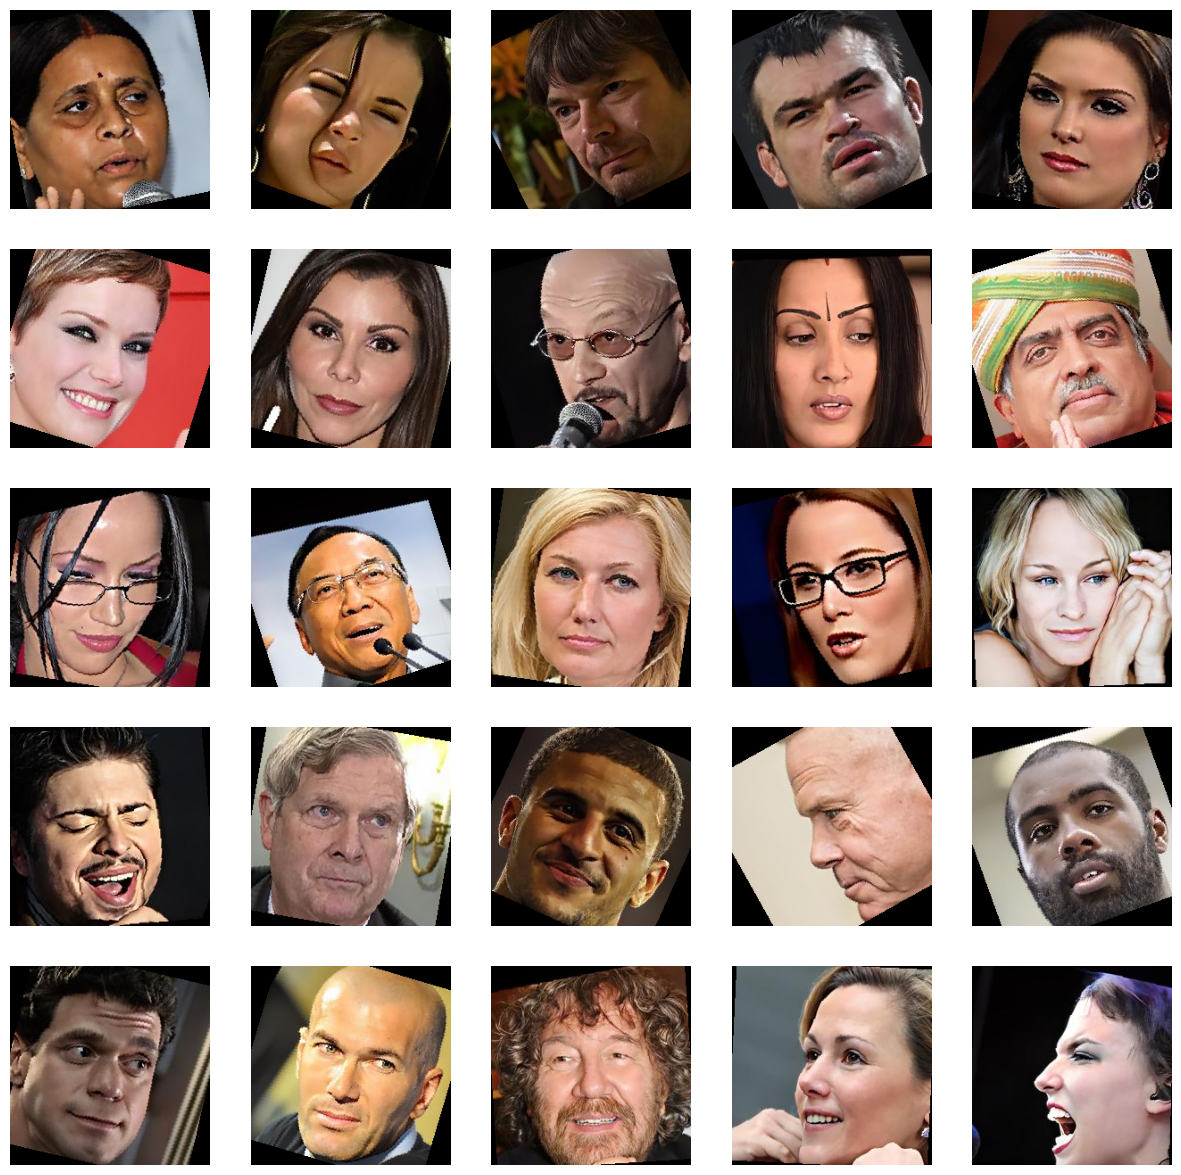

In [6]:
# Visualize a few images in the dataset
# You can write your own code, and you don't need to understand the code
# It is highly recommended that you visualize your data augmentation as sanity check

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(TRAIN_DIR, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True,
)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

# Very Simple Network (for Mandatory Early Submission)

In [ ]:
class Network(torch.nn.Module):
    """
    The Very Low early deadline architecture is a 5-layer CNN. Keep in mind the parameter limit is 21M.

    The first Conv layer has 64 channels, kernel size 7, and stride 4.
    The next three have 128, 256, 512 and 1024 channels. Each have kernel size 3 and stride 2.

    Think about strided convolutions from the lecture, as convolutioin with stride= 1 and downsampling.
    For stride 1 convolution, what padding do you need for preserving the spatial resolution?
    (Hint => padding = kernel_size // 2) - Why?)

    Each Conv layer is accompanied by a Batchnorm and ReLU layer.
    Finally, you want to average pool over the spatial dimensions to reduce them to 1 x 1. Use AdaptiveAvgPool2d.
    Then, remove (Flatten?) these trivial 1x1 dimensions away.
    Look through https://pytorch.org/docs/stable/nn.html

    TODO: Fill out the model definition below!

    Why does a very simple network have 4 convolutions?
    Input images are 224x224. Note that each of these convolutions downsample.
    Downsampling 2x effectively doubles the receptive field, increasing the spatial
    region each pixel extracts features from. Downsampling 32x is standard
    for most image models.

    Why does a very simple network have high channel sizes?
    Every time you downsample 2x, you do 4x less computation (at same channel size).
    To maintain the same level of computation, you 2x increase # of channels, which
    increases computation by 4x. So, balances out to same computation.
    Another intuition is - as you downsample, you lose spatial information. We want
    to preserve some of it in the channel dimension.
    """

    def __init__(self, num_classes=7001):
        super().__init__()
        self.convnext = torchvision.models.convnext_base(pretrained=True).features.eval()
        self.backbone = torch.nn.Sequential(
            self.convnext
        )

        self.cls_layer = torch.nn.Sequential([
            torch.nn.Linear(1024*7*7, 28000),
            torch.nn.Linear(28000, num_classes)
        ])

    def forward(self, x, return_feats=False):
        """
        What is return_feats? It essentially returns the second-to-last-layer
        features of a given image. It's a "feature encoding" of the input image,
        and you can use it for the verification task. You would use the outputs
        of the final classification layer for the classification task.

        You might also find that the classification outputs are sometimes better
        for verification too - try both.
        """
        feats = self.backbone(x)
        out = self.cls_layer(feats)

        if return_feats:
            return feats
        else:
            return out

model = Network().to(DEVICE)
# summary(model, (3, 224, 224))

/home/alice/anaconda3/envs/whisper/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alice/anaconda3/envs/whisper/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# when using MobileNet
model = MobileNetV2(num_classes=7001).to(DEVICE)
# when using EfficientNet
# model = EfficientNet(num_classes=7001).to(DEVICE)
torch.cuda.empty_cache()

In [5]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
print(sum([param.numel() for param in model.parameters()]))
for i, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    feats, logits = model(images, return_feats=True)
    print(feats.shape)
    break

7372005
torch.Size([64, 512])


# Setup everything for training

In [17]:
criterion = torch.nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.SGD(model.parameters(), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.7)
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler() # Good news. We have FP16 (Mixed precision training) implemented for you
# It is useful only in the case of compatible GPUs such as T4/V100

# Let's train!

In [7]:
def train(model, dataloader, optimizer, criterion):

    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            outputs = model(images)
            loss    = criterion(outputs, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss      += float(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    scheduler.step()
    batch_bar.close() # You need this to close the tqdm bar

    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [10]:
def validate(model, dataloader, criterion):

    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    num_correct = 0.0
    total_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):

        # Move images to device
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        # Get model outputs
        with torch.inference_mode():
            outputs = model(images)
            loss = criterion(outputs, labels)

        num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())

        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss="{:.04f}".format(float(total_loss / (i + 1))),
            num_correct=num_correct)

        batch_bar.update()

    batch_bar.close()
    acc = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    return acc, total_loss

In [11]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

# Wandb

In [5]:
wandb.login(key="1d70da927fe2f85af2f2aa8e4861950d6f63844e") #API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/alice/.netrc
wandb: Currently logged in as: khjune29 (cvl2023) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [6]:
# Create your wandb run
run = wandb.init(
    name = "mobilenet-ARC-verification", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


# Experiments

In [14]:
best_valacc = 0.0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)

    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))

    val_acc, val_loss = validate(model, valid_loader, criterion)

    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))

    wandb.log({"train_loss":train_loss, 'train_Acc': train_acc, 'validation_Acc':val_acc,
               'validation_loss': val_loss, "learning_Rate": curr_lr})

    # If you are using a scheduler in your train function within your iteration loop, you may want to log
    # your learning rate differently

    # #Save model in drive location if val_acc is better than best recorded val_acc
    if val_acc >= best_valacc:
      #path = os.path.join(root, model_directory, 'checkpoint' + '.pth')
      print("Saving model")
      torch.save({'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict(),
                  'scheduler_state_dict':scheduler.state_dict(),
                  'val_acc': val_acc,
                  'epoch': epoch}, './checkpoint.pth')
      best_valacc = val_acc
      wandb.save('checkpoint.pth')
      # You may find it interesting to exlplore Wandb Artifcats to version your models
run.finish()


Epoch 1/20: 
Train Acc 0.0136%	 Train Loss 8.8641	 Learning Rate 0.0500


Val Acc 0.0371%	 Val Loss 8.7593
Saving model



Epoch 2/20: 
Train Acc 0.0750%	 Train Loss 8.4866	 Learning Rate 0.0500


Val Acc 0.2171%	 Val Loss 7.9698
Saving model



Epoch 3/20: 
Train Acc 0.7513%	 Train Loss 7.3393	 Learning Rate 0.0500


Val Acc 1.8567%	 Val Loss 6.7609
Saving model



Epoch 4/20: 
Train Acc 3.6285%	 Train Loss 6.1799	 Learning Rate 0.0500


Val Acc 6.1415%	 Val Loss 5.7197
Saving model



Epoch 5/20: 
Train Acc 8.8201%	 Train Loss 5.3256	 Learning Rate 0.0500


Val Acc 11.3488%	 Val Loss 5.1004
Saving model



Epoch 6/20: 
Train Acc 18.3287%	 Train Loss 4.4144	 Learning Rate 0.0350


Val Acc 19.1242%	 Val Loss 4.4402
Saving model



Epoch 7/20: 
Train Acc 24.9257%	 Train Loss 3.9221	 Learning Rate 0.0350


Val Acc 24.5430%	 Val Loss 4.0834
Saving model



Epoch 8/20: 
Train Acc 31.4835%	 Train Loss 3.4853	 Learning Rate 0.0350


Val Acc 30.8729%	 Val Loss 3.6675
Saving model



Epoch 9/20: 
Train Acc 37.3457%	 Train Loss 3.1219	 Learning Rate 0.0350


Val Acc 36.1460%	 Val Loss 3.3057
Saving model



Epoch 10/20: 
Train Acc 42.5281%	 Train Loss 2.8294	 Learning Rate 0.0350


Val Acc 38.4027%	 Val Loss 3.2378
Saving model



Epoch 11/20: 
Train Acc 53.0564%	 Train Loss 2.2811	 Learning Rate 0.0245


Val Acc 48.4061%	 Val Loss 2.7018
Saving model



Epoch 12/20: 
Train Acc 56.0193%	 Train Loss 2.1073	 Learning Rate 0.0245


Val Acc 49.5058%	 Val Loss 2.6399
Saving model



Epoch 13/20: 
Train Acc 58.6230%	 Train Loss 1.9610	 Learning Rate 0.0245


Val Acc 51.7882%	 Val Loss 2.5127
Saving model



Epoch 14/20: 
Train Acc 60.9404%	 Train Loss 1.8362	 Learning Rate 0.0245


Val Acc 51.6710%	 Val Loss 2.5181



Epoch 15/20: 
Train Acc 63.2148%	 Train Loss 1.7202	 Learning Rate 0.0245


Val Acc 55.0417%	 Val Loss 2.3398
Saving model



Epoch 16/20: 
Train Acc 71.2594%	 Train Loss 1.3664	 Learning Rate 0.0171


Val Acc 59.8835%	 Val Loss 2.1220
Saving model



Epoch 17/20: 
Train Acc 72.7077%	 Train Loss 1.2801	 Learning Rate 0.0171


Val Acc 60.1005%	 Val Loss 2.1088
Saving model



Epoch 18/20: 
Train Acc 73.9731%	 Train Loss 1.2147	 Learning Rate 0.0171


Val Acc 62.4771%	 Val Loss 1.9898
Saving model



Epoch 19/20: 
Train Acc 75.0186%	 Train Loss 1.1563	 Learning Rate 0.0171


Val Acc 63.7169%	 Val Loss 1.9407
Saving model



Epoch 20/20: 
Train Acc 75.9119%	 Train Loss 1.1046	 Learning Rate 0.0171


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Val Acc 64.1482%	 Val Loss 1.9225
Saving model


learning_Rate,█████▅▅▅▅▅▃▃▃▃▃▁▁▁▁▁
train_Acc,▁▁▁▁▂▃▃▄▄▅▆▆▆▇▇█████
train_loss,██▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
validation_Acc,▁▁▁▂▂▃▄▄▅▅▆▆▇▇▇█████
validation_loss,█▇▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁
learning_Rate,0.01715
train_Acc,75.91193
train_loss,1.10457
validation_Acc,64.14819
validation_loss,1.92247


# Classification Task: Testing

In [ ]:
def test(model,dataloader):

  model.eval()
  batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Test')
  test_results = []

  for i, (images) in enumerate(dataloader):
      # TODO: Finish predicting on the test set.
      images = images.to(DEVICE)

      with torch.inference_mode():
        outputs = model(images)

      outputs = torch.argmax(outputs, axis=1).detach().cpu().numpy().tolist()
      test_results.extend(outputs)

      batch_bar.update()

  batch_bar.close()
  return test_results

In [ ]:
test_results = test(model, test_loader)

## Generate csv to submit to Kaggle

In [ ]:
with open("classification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(test_dataset)):
        f.write("{},{}\n".format(str(i).zfill(6) + ".jpg", test_results[i]))

In [ ]:
!kaggle competitions submit -c 11-785-f23-hw2p2-classification -f classification_early_submission.csv -m "early submission"

# Verification Task: Validation

The verification task consists of the following generalized scenario:
- You are given X unknown identitites
- You are given Y known identitites
- Your goal is to match X unknown identities to Y known identities.

We have given you a verification dataset, that consists of 960 known identities, and 1080 unknown identities. The 1080 unknown identities are split into dev (360) and test (720). Your goal is to compare the unknown identities to the 1080 known identities and assign an identity to each image from the set of unknown identities. Some unknown identities do not have correspondence in known identities, you also need to identify these and label them with a special label n000000.

Your will use/finetune your model trained for classification to compare images between known and unknown identities using a similarity metric and assign labels to the unknown identities.

This will judge your model's performance in terms of the quality of embeddings/features it generates on images/faces it has never seen during training for classification.

In [7]:
# This obtains the list of known identities from the known folder
known_regex = "11-785-f23-hw2p2-verification/known/*/*"
known_paths = [i.split('/')[-2] for i in sorted(glob.glob(known_regex))]

# Obtain a list of images from unknown folders
unknown_dev_regex = "11-785-f23-hw2p2-verification/unknown_dev/*"
unknown_test_regex = "11-785-f23-hw2p2-verification/unknown_test/*"

# We load the images from known and unknown folders
unknown_dev_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_dev_regex)))]
unknown_test_images = [Image.open(p) for p in tqdm(sorted(glob.glob(unknown_test_regex)))]
known_images = [Image.open(p) for p in tqdm(sorted(glob.glob(known_regex)))]

# Why do you need only ToTensor() here?
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

unknown_dev_images = torch.stack([transforms(x) for x in unknown_dev_images])
unknown_test_images = torch.stack([transforms(x) for x in unknown_test_images])
known_images  = torch.stack([transforms(y) for y in known_images ])
#Print your shapes here to understand what we have done

# You can use other similarity metrics like Euclidean Distance if you wish
similarity_metric = torch.nn.CosineSimilarity(dim= 1, eps= 1e-6)

100%|██████████| 960/960 [00:00<00:00, 19949.82it/s]


In [8]:
def eval_verification(unknown_images, known_images, model, similarity, batch_size= config['batch_size'], mode='val'):

    unknown_feats, known_feats = [], []

    batch_bar = tqdm(total=len(unknown_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)
    model.eval()

    # We load the images as batches for memory optimization and avoiding CUDA OOM errors
    for i in range(0, unknown_images.shape[0], batch_size):
        unknown_batch = unknown_images[i:i+batch_size] # Slice a given portion upto batch_size

        with torch.no_grad():
            unknown_feat, logits = model(unknown_batch.float().to(DEVICE), return_feats=True) #Get features from model
        unknown_feats.append(unknown_feat)
        batch_bar.update()

    batch_bar.close()

    batch_bar = tqdm(total=len(known_images)//batch_size, dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i in range(0, known_images.shape[0], batch_size):
        known_batch = known_images[i:i+batch_size]
        with torch.no_grad():
              known_feat, logits = model(known_batch.float().to(DEVICE), return_feats=True)

        known_feats.append(known_feat)
        batch_bar.update()

    batch_bar.close()

    # Concatenate all the batches
    unknown_feats = torch.cat(unknown_feats, dim=0)
    known_feats = torch.cat(known_feats, dim=0)

    similarity_values = torch.stack([similarity(unknown_feats, known_feature) for known_feature in known_feats])
    # Print the inner list comprehension in a separate cell - what is really happening?

    max_similarity_values, predictions = similarity_values.max(0) #Why are we doing an max here, where are the return values?
    max_similarity_values, predictions = max_similarity_values.cpu().numpy(), predictions.cpu().numpy()


    # Note that in unknown identities, there are identities without correspondence in known identities.
    # Therefore, these identities should be not similar to all the known identities, i.e. max similarity will be below a certain
    # threshold compared with those identities with correspondence.

    # In early submission, you can ignore identities without correspondence, simply taking identity with max similarity value
    pred_id_strings = [known_paths[i] for i in predictions] # Map argmax indices to identity strings

    # After early submission, remove the previous line and uncomment the following code

    threshold = 0.2# Choose a proper threshold
    NO_CORRESPONDENCE_LABEL = 'n000000'
    pred_id_strings = []
    for idx, prediction in enumerate(predictions):
        if max_similarity_values[idx] < threshold: # why < ? Thank about what is your similarity metric
            pred_id_strings.append(NO_CORRESPONDENCE_LABEL)
        else:
            pred_id_strings.append(known_paths[prediction])
    
    accuracy = 0.0
    if mode == 'val':
      true_ids = pd.read_csv('11-785-f23-hw2p2-verification/verification_dev.csv')['label'].tolist()
      accuracy = accuracy_score(pred_id_strings, true_ids)
      print("Verification Accuracy = {}".format(accuracy))
    
    return accuracy, pred_id_strings

In [13]:
# verification eval
_, pred_id_strings = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
# verification test
_, pred_id_strings = eval_verification(unknown_test_images, known_images, model, similarity_metric, config['batch_size'], mode='test')

Verification Accuracy = 0.39444444444444443


In [10]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
model.load_state_dict(torch.load("checkpoint.pth")["model_state_dict"])


<All keys matched successfully>

In [12]:
print(len(list(model.features.children())))
for module in model.features.children():
    module.requires_grad_(False)
model.features[15].requires_grad_(True)

16


Conv2dNormActivation(
  (layers): Sequential(
    (0): Conv2d(320, 1024, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6()
  )
)

In [9]:
# add your finetune/retrain code here
# model = Network().to(DEVICE)
arcface_loss = ArcFace(embed_dim=512).cuda()
criterion = nn.CrossEntropyLoss()
def train(model, dataloader, optimizer, criterion):
    model.train()

    # Progress Bar
    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    num_correct = 0
    total_loss  = 0
    total_cls_loss      = 0
    total_center_loss   = 0
    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        images, labels = images.to(DEVICE), labels.to(DEVICE)

        with torch.cuda.amp.autocast(): # This implements mixed precision. Thats it!
            features, outputs = model(images, return_feats=True)
            cos_values, cosine = arcface_loss(features, labels)
            loss = criterion(cos_values, labels)

        # Update no. of correct predictions & loss as we iterate
        num_correct     += int((torch.argmax(cosine, axis=1) == labels).sum())
        total_loss      += float(loss.item())
        
        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            num_correct = num_correct,
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()

        # TODO? Depending on your choice of scheduler,
        # You may want to call some schdulers inside the train function. What are these?

        batch_bar.update() # Update tqdm bar

    scheduler.step()
    
    batch_bar.close() # You need this to close the tqdm bar
    
    acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [10]:
criterion = torch.nn.CrossEntropyLoss()# TODO: What loss do you need for a multi class classification problem?
optimizer = torch.optim.SGD(list(model.parameters())+list(arcface_loss.parameters()), lr=config['lr'], momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.7)
# TODO: Implement a scheduler (Optional but Highly Recommended)
# You can try ReduceLRonPlateau, StepLR, MultistepLR, CosineAnnealing, etc.
scaler = torch.cuda.amp.GradScaler()

In [11]:
for epoch in range(config['epochs']):
    val_acc, _ = eval_verification(unknown_dev_images, known_images, model, similarity_metric, config['batch_size'], mode='val')
    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    wandb.log({
        "verification_Acc": val_acc,
        "train_loss": train_loss,
        "train_Acc": train_acc,
    })

Verification Accuracy = 0.002777777777777778


Verification Accuracy = 0.05


Verification Accuracy = 0.07777777777777778


Verification Accuracy = 0.125


Verification Accuracy = 0.14722222222222223


Verification Accuracy = 0.16944444444444445


Verification Accuracy = 0.20555555555555555


Verification Accuracy = 0.22777777777777777


Verification Accuracy = 0.25


Verification Accuracy = 0.24722222222222223


Verification Accuracy = 0.25833333333333336


Verification Accuracy = 0.3


Verification Accuracy = 0.28888888888888886


Verification Accuracy = 0.3194444444444444


Verification Accuracy = 0.29444444444444445


Verification Accuracy = 0.3277777777777778


Verification Accuracy = 0.31666666666666665


Verification Accuracy = 0.325


Verification Accuracy = 0.35833333333333334


Verification Accuracy = 0.3416666666666667


Verification Accuracy = 0.34444444444444444


Verification Accuracy = 0.3888888888888889


Verification Accuracy = 0.375


Verification Accuracy = 0.3611111111111111


Verification Accuracy = 0.36944444444444446


Verification Accuracy = 0.3638888888888889


Verification Accuracy = 0.37777777777777777


Verification Accuracy = 0.37777777777777777


Verification Accuracy = 0.37222222222222223


Verification Accuracy = 0.3972222222222222


Verification Accuracy = 0.3888888888888889


Verification Accuracy = 0.40555555555555556


Verification Accuracy = 0.4


Verification Accuracy = 0.4027777777777778


Verification Accuracy = 0.4083333333333333


Verification Accuracy = 0.425


Verification Accuracy = 0.4083333333333333


Verification Accuracy = 0.39166666666666666


Verification Accuracy = 0.40555555555555556


Verification Accuracy = 0.4027777777777778


## Generate csv to submit to Kaggle

In [14]:
with open("verification_early_submission.csv", "w+") as f:
    f.write("id,label\n")
    for i in range(len(pred_id_strings)):
        f.write("{},{}\n".format(i, pred_id_strings[i]))

In [15]:
!kaggle competitions submit -c 11-785-f23-hw2p2-verification -f verification_early_submission.csv -m "early submission"

100%|██████████████████████████████████████| 8.34k/8.34k [00:01<00:00, 8.41kB/s]
Successfully submitted to Face Verification